In [77]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
%matplotlib inline

In [78]:
def correct(x):
    """Function to correct for round-off errors to 7 
       decimal places.
       
       Args:
       -----
       x    : an ndarray.
       
       Returns:
       --------
       y    : an ndarray correction of x.
    """
#   Tolarance:
    tol = 1.0e-07
    sign = np.sign(x)
    y = np.abs(x)
    
#   correct for precision:
    for i in np.arange(np.size(x)):
        if np.abs(y[i] - 1.0) < tol:
            y[i] = 1.0
        elif np.abs(y[i] - 0.0) < tol:
            y[i] = 0.0

    return y * sign
######################## simple test #################
#if __name__ == "__main__":
#    x = [1e-8, 1e-5]
#    print correct(x)

In [79]:
def mapphi(alpha, beta, phi):
    """Function to map the rotational axis:
       
       Args:
       -----
       alpha       : magnetic inclination angle w.r.t the rotatinal axis (degrees)
       beta        : line of sight closest approach to the magnetic axis (degrees)
       
       Returns:
       --------
       xlos, ylos  : The coordinates of the rotatinal plane; both the size of phi.
       
    """
    cosR = np.cos(np.deg2rad(alpha+beta)) * np.cos(np.deg2rad(alpha))
    cosR += np.sin(np.deg2rad(alpha+beta)) * np.sin(np.deg2rad(alpha)) * np.cos(np.deg2rad(phi))

    R = np.arccos(correct(cosR))

    # problems with precision for 180 degrees
    cosgamma = np.zeros_like(R)

    for i in np.arange(len(R)):
        if int(R[i]*100.0) == 180.0:
            R[i] = int(R[i]*100.0)/100.0
        if R[i] != 0.0 and R[i] != 180.0 and alpha > 0.0:
            cosgamma[i] = (np.cos(np.deg2rad(alpha+beta)) - np.cos(np.deg2rad(alpha)) * cosR[i]) \
                  /(np.sin(np.deg2rad(alpha)) * np.sin(R[i]))
        else:
             cosgamma[i] = 0.0

    cosgamma_corr = correct(cosgamma)
    gamma = np.arccos(cosgamma_corr)
    xp = R * np.sin(gamma)
    
    for i in np.arange(len(phi)):
        if phi[i] > 0.0:
            xp[i] = -xp[i]

    yp = -R * np.cos(gamma)
     
    return xp, yp
#############################################
if __name__ == "__main__":
    phi= np.linspace(-180, 180, num=500, endpoint=True)
    alpha = 10
    beta = 3
    xlos, ylos =  mapphi(alpha, beta, phi)


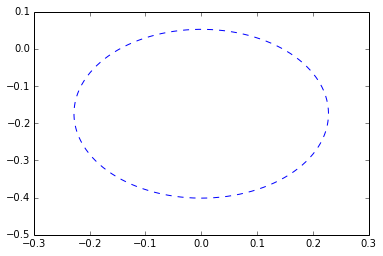

In [80]:
def los(alpha, beta):
    """Function to determine the line of sight cut across the beam.
    
       Args:
       -----
       alpha       : inclination angle
       beta        : impact parameter
       
       Returns:
       --------
       xlos        : the line of sight x-coordinates
       ylos        : the line of sight y-coordinates
       thetalos : the line of sight angle in degrees
    """

#   rotational phase:
    phi = np.linspace(-180, 180, num=500, endpoint=True)
    
#   line of sight x,y plane:
    xlos, ylos = mapphi(alpha, beta, phi)
    thetalos = np.arctan2(ylos, xlos) * (180 / np.pi) - 90.0
    for i in np.arange(len(thetalos)):
        if thetalos[i] < 0:
            thetalos[i] = -thetalos[i]       
            
    return xlos, ylos, thetalos
################## test ######################
if __name__ == "__main__":
    xlos, ylos, thetalos = los(alpha, beta)
    plt.plot(xlos, ylos, 'b--')

In [81]:
def emission_height(P, hmin, hmax, ncomp):
    """Function to determine emission heights given hmin and hmax. Allowed emision heights for young 
       pulsars range between [950, 1000] and between [20, 1000] for old pulsars.
    
       Args:
       -----
       P      : rotational period.
       hmin   : minimum emission height (in km).
       hmax   : maximum emission height (in km).
       ncomp  : integer number of component .
       
       Returns:
       --------
       H      : random emission height.
    """
    
#   num_H = np.random.randint(3,8), number of discrete emission height 
    num_H = ncomp
    
#   emission height for a short period pulsar: only one emission height 
    if P <= 0.15:
        if hmin >= 950 and hmax <= 1000:
            H = np.random.uniform(hmin, hmax, size=1)
            
        else: print "error, emission range not allowed for pulse period P < 0.15 seconds"
            
#   emission height for a long period pulsar:        
    if P > 0.15:
        if hmin >= 20 and hmax <= 1000:
            H = np.random.uniform(hmin, hmax, size=num_H)
        
        else: print "error, emission range not allowed for pulse period P > 0.15 seconds"
        
    return H

########################### simple test #############################
if __name__ == "__main__":
    P = 0.16
    hmin = 50
    hmax = 1000
    ncomp = 4
    heights = emission_height(P, hmin, hmax, ncomp)
    print "heigths = ",heights,"km"  

heigths =  [ 416.59951517  376.04726083  871.90432316  439.84265428] km


In [82]:
from scipy import constants
#import emission_height

def rho(P, heights):
    """Function to determine the opening angle rho given the rotational period and emission height.
       
    
       Args:
       -----
       P         : rotational period (seconds)
       heights   : emission heights (km)
       
       Returns:
       --------
       rho       : the opening angle (degrees)
       
    """

#   opening angle (eqn 3.29, Lorimer and Kramer 2005):
    rho = np.rad2deg(np.sqrt((9 * np.pi * heights) / (2 * (constants.c / 1000) * P)))   
    
    return rho

#################### simple test #####################################
if __name__ == "__main__":
    opa = rho(P, heights)
    print "opening angle =",opa,"degrees"

opening angle = [ 20.07672466  19.07456742  29.0447671   20.62918899] degrees


In [83]:
def patch_width(P, heights):
    """Function to calculate the width of a patchy emission region 
       within a pulsar beam at a given height.
    
       Args:
       -----
       P             : rotational period (seconds).
       heights       : emission heights (km).
      
       
       Returns:
       --------
       patchwidths   : the width of the patchy emission region (degrees).
       
    """   
    
#   width of the patch (eqn 3, KJ2007):
    patchwidths = 2.45 * 0.2 * np.sqrt(heights / ( 10 * P)) 
    
    return patchwidths
#################### simple test ################################################
if __name__ == "__main__":
    patchwidths = patch_width(P, heights)
    print "patch width =",patchwidths,"degrees"


patch width = [  7.90670379   7.51202982  11.4385376    8.12427771] degrees


In [84]:
def patch_center(P, heights):
    """Function find centres of the patches
       
       Args:
       -----
       P       : rotatinal period
       heights : emission heights (in km).
       
       
       Returns:
       --------
       centerx : the patch center projection on the x-axis 
       centery : the patch center projection on the y-axis 
    """
    
#   opening angle:    
    opa = rho(P, heights) 
    
#   initialize the array:
    centerx = []
    centery = []
    
    for comp in opa: #for each emission height (comp!)
#       number of active patches (table 2, KJ2007): 
        npatch = np.random.randint(2,10+1)
        tempCenterX = []
        tempCenterY = []
        theta = 2 * np.pi * np.random.random(npatch)

#       centers for short periods:
        if P <= 0.15:
            if hmin >= 950 and hmax <= 1000:
                for i in np.arange(npatch):
                    tempCenterX.append(comp * np.sin(theta[i]))
                    tempCenterY.append(comp * np.cos(theta[i]))
                
#       centers for longer periods:
        if P > 0.15:
            if hmin >= 20 and hmax <= 1000:
                for i in np.arange(npatch):
                    tempCenterX.append(comp * np.sin(theta[i]))
                    tempCenterY.append(comp * np.cos(theta[i]))
        centerx.append(tempCenterX)
        centery.append(tempCenterY)
        
        print "acive patches: " ,npatch
        
    return centerx, centery

########################### simple test ###########################
if __name__ == "__main__":
    cx, cy = patch_center(P, heights)
    for i in range(len(cx)):
        print 'height %i:\n'%i, cx[i], '\n', cy[i], '\n'

acive patches:  3
acive patches:  6
acive patches:  6
acive patches:  8
height 0:
[-17.517654999179843, 19.763356147708894, 19.625961644913598] 
[9.808498172560606, -3.5333591453788586, 4.230425815895571] 

height 1:
[18.802856480495514, 11.399974972712405, 18.846384260020862, 17.69333119312676, 18.473490997092654, 6.9599419581437534] 
[-3.2080695779063779, -15.293125673462942, -2.9415850432102895, 7.1263702916090592, -4.7507107492602918, 17.759457485578515] 

height 2:
[23.878639194085231, -24.585873649862766, -11.87284481582234, 25.427723169105732, -27.975372795344981, 3.7728666917543316] 
[16.535086517180222, 15.4639358756082, 26.507245271271383, -14.036715795629055, -7.8087779359776084, 28.798680053401569] 

height 3:
[10.903080589203837, -19.930767237667052, -15.003633787811689, 11.235471738835269, 13.139378517642223, 6.025162261941734, 20.336247520259548, -11.255134493381025] 
[-17.512460475347378, 5.3224012957701126, -14.158192377436931, 17.301087047960646, -15.903464100798912, 

In [85]:
def scatter(prof,dm,period,freq):
    """
    Function to perform convolution for a scattered profile. If dm = 0, the function
    returns the input profile without convolution. 
    
    Args:
    -----

        prof   : an array of the profile
        dm     : dispersion measure in cm^-3 pc.
        period : rotational period in seconds.
        freq   : observing frequency in GHz.

    Returns:
    --------

        conv   : convolution of the profile.

    """

    if dm != 0:
        
        #npts = float(prof.shape[0])
        npts = float(len(prof))
        tbin = (period * 1000) / npts    # tbin = time of each bin in ms.
        log_tau = -6.46 + 0.154 * np.log10(dm) + 1.07 * (np.log10(dm))**2 - 3.86 * np.log10(freq)
#       tau = scattering time scale as in Bhat et al. (2004) in ms.
        tau = 10**log_tau
        tcrit = -tau / np.log(0.01)
        bincrit = tcrit / tbin

        verbose = raw_input('verbose (y/n)? : ')
        if verbose is 'y':
            print "Scattering for tau = " + str(tau) + ", dm = " + str(dm) + \
            ", period = " + str(period) + ", freq = " + str(freq) + ", tbin = " + str(tbin)
        

        if bincrit > 10 * npts: bincrit = 10 * npts

        if bincrit < npts: bincrit = npts

        if verbose is 'y': print "Critical bin: " + str(bincrit)
        
#       Convolution:
#       1. Transpose the profile:
        
        tprof = prof[::-1]

#       2. Slide along the time axis for as long as the scatter response is still high enough
#          (tb = straight bin number, tbf = folded bin number)
        tb = 0
        tbf = 0
        
        conv = np.zeros(int(npts))
        #scr = np.zeros(int(npts))
        while tb < bincrit + npts - 1:

            #print tbf, conv.shape, npts, bincrit+npts-1
            #the loops slows down the program
            for i in np.arange(int(npts) - 1):
               
                if tb + i - 1 > npts:
                    frac = (tb + i - 1 - npts) * tbin / tau
                    scr = np.exp(-frac)
                else: 
                    scr = 0.0
                
                if scr != 0.0:
                    #conv[tbf] = tprof[i] * scr[i]
                    conv[tbf] += tprof[i] * scr
                else: conv[tbf] += tprof[i]

            tb += 1
            tbf += 1
            if tbf > int(npts) - 1: tbf=1 
       
    
    if dm == 0.: 
        print('No scattering for dm == 0; returning the profile without convolution!')
        conv = prof 
    return conv

###############################################################################################
#simple test statement

if __name__ == "__main__":
    prof = np.arange(200)
    dm = 200
    period = 0.5
    freq = 0.3
    aa = scatter(prof, dm, period, freq)
    print aa

verbose (y/n)? : n
[ 19900.          22967.53056018  22784.17517842  22599.81979862
  22427.18442491  22265.45599936  22113.87343436  21971.72429076
  21838.34166821  21713.10129443  21595.41880034  21484.74716953
  21380.57435067  21282.42102255  21189.838502    21102.4067855
  21019.73271599  20941.44826687  20867.20893565  20796.69224032
  20729.59631179  20665.63857633  20604.5545222   20546.09654519
  20490.03286781  20436.14652772  20384.23443074  20334.10646438
  20285.58466806  20238.50245639  20192.70389205  20148.04300517
  20104.38315622  20061.59643961  20019.56312545  19978.1711369
  19937.31556108  19896.89819105  19856.82709725  19817.01622621
  19777.38502499  19737.85808952  19698.36483557  19658.83919061
  19619.21930543  19579.44728422  19539.46893183  19499.23351726
  19458.6935522   19417.80458379  19376.52500056  19334.81585085
  19292.64067276  19249.96533503  19206.75788806  19162.98842445
  19118.62894846  19073.65325385  19028.03680945  18981.75665213
  18934.

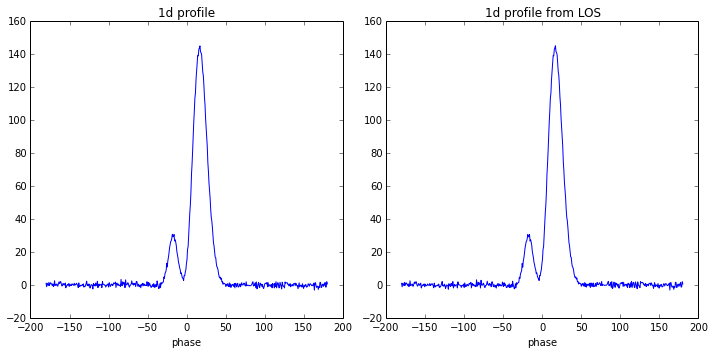

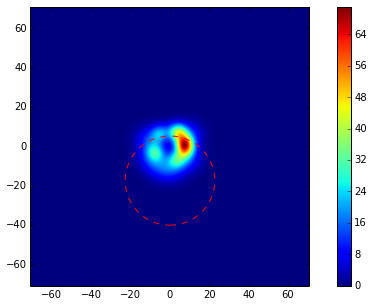

In [86]:
#import d2r
def plotpatch(P, alpha, beta, heights, centerx, centery):
    """Function to plot the patches for a given height range. Using a 2d gaussian
    
       Args:
       -----
       P       : rotational period (seconds)
       alpha   : inclination angle (degrees)
       beta    : impact parameter (degrees)
       heights : emission heights (in km)
       centerx : the patch center projection on the x-axis 
       centery : the patch center projection on the y-axis 
       
       Returns:
       --------
       A plot of the patches projected on to observational plane.
    
    """    
    
#   initialize parameters:
    x = np.linspace(-180, 180, num=500, endpoint=True)
    y = np.linspace(-180, 180, num=500, endpoint=True)
    X,Y = np.meshgrid(x,y)
    gauss = np.zeros(len(x))
    Z = np.zeros_like(X)

#   find the width of the patches:
    patchwidths = patch_width(P, heights)
      
    
#   An arbitrary peak of the profile:
    peak = 10. 
    
#   Get the line of sight:
    xlos, ylos, thetalos = los(alpha, beta)

    for cid, comp in enumerate(heights):
#       widths for circular patches:        
        sigmax = patchwidths[cid]
        sigmay = patchwidths[cid]
    
#       center of the patch:
        patchCenterX = centerx[cid]
        patchCenterY = centery[cid]
        
#       1D gassian profile:
        for cen in np.arange(len(patchCenterX)):
            gauss += peak * np.exp(-((x - patchCenterX[0]) / sigmax)**2)
        
#       2D gaussian:
        for pc in zip(patchCenterX, patchCenterY):
            Z += peak*np.exp(-((X - pc[0])**2 / (2*sigmax**2) + (Y - pc[1])**2 / (2*sigmay**2)))
            
#   add noise: a normal distibution with zero mean, and std dev = 1
    noise = np.random.normal(0, 1, 500)
    gauss = gauss + noise
    


#   profile plot:

    prof = gauss - xlos
    fig1 = plt.figure(figsize=(10,5))
    ax1 = plt.subplot(1, 2, 1)
    plt.title("1d profile")
    plt.xlabel("phase")
    plt.tight_layout()
    plt.plot(x, gauss)
    
    plt.subplot(1, 2, 2, sharey=ax1)
    plt.title("1d profile from LOS")
    plt.xlabel("phase")
    plt.tight_layout()
    plt.plot(x, prof)
    
#   scattered profile:
    #prof_scatter = scatter(gauss, dm, period,freq)
    #plt.figure()
    #plt.title("1d scattered profile")
    #plt.xlabel("phase")
    #plt.plot(x, prof_scatter)
    
#   patchy emission region:

    plt.figure(figsize=(10, 5))
    plt.plot(1e2*xlos, 1e2*ylos, '--r')
    plt.imshow(Z, extent=[-np.amax(Z),np.amax(Z),-np.amax(Z),np.amax(Z)])#, cmap=cm.gray)
    plt.colorbar()
    
############################ simple test ##########################
if __name__ == "__main__":
    plotpatch(P, alpha, beta, heights, cx, cy)